In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('../data/train.csv', index_col="ID")
test = pd.read_csv('../data/test.csv', index_col="ID")

In [3]:
train.head()

,measurement_time,target,source_1_temperature,source_2_temperature,source_3_temperature,source_4_temperature,mean_room_temperature,sun_radiation_east,sun_radiation_west,sun_radiation_south,sun_radiation_north,sun_radiation_perpendicular,outside_temperature,wind_speed,wind_direction,clouds
ID,,,,,,,,,,,,,,,,
0,2023-11-01 00:00:00,3.400000,27.600000,18.799999,19.750000,21.100000,20.129892,0.0,0.0,0.0,0.0,0.0,8.97,2.06,140.0,20.0
1,2023-11-01 01:00:00,2.933333,28.400000,18.933333,19.833333,21.033333,20.052919,0.0,0.0,0.0,0.0,0.0,9.19,2.06,110.0,100.0
2,2023-11-01 02:00:00,7.166667,29.400000,19.000000,19.799999,21.000000,19.992375,0.0,0.0,0.0,0.0,0.0,9.42,2.57,140.0,20.0
3,2023-11-01 03:00:00,10.500000,30.100000,19.033333,19.933333,24.600000,19.941565,0.0,0.0,0.0,0.0,0.0,9.19,2.57,150.0,100.0
4,2023-11-01 04:00:00,8.733334,31.866666,19.100000,20.000000,24.700000,19.924502,0.0,0.0,0.0,0.0,0.0,9.99,2.57,160.0,100.0


In [4]:
train.describe()

,target,source_1_temperature,source_2_temperature,source_3_temperature,source_4_temperature,mean_room_temperature,sun_radiation_east,sun_radiation_west,sun_radiation_south,sun_radiation_north,sun_radiation_perpendicular,outside_temperature,wind_speed,wind_direction,clouds
count,7047.000000,7047.000000,7047.000000,7047.000000,7047.000000,7047.000000,7047.000000,7047.000000,7047.000000,7047.000000,7047.000000,7047.000000,7047.000000,7047.000000,7044.000000
mean,13.902992,31.353220,18.285482,18.765825,21.941836,20.591658,131.326270,136.768829,195.958575,47.121580,307.383654,11.023374,4.259801,187.591599,70.425327
std,11.582678,5.961416,1.388247,1.616728,2.111493,1.067446,218.094756,219.425579,272.681407,57.183783,351.661306,6.481420,2.360655,89.276916,33.634026
min,0.466667,17.400000,14.750000,15.200000,16.566667,17.706746,0.000000,0.000000,0.000000,0.000000,0.000000,-5.840000,0.000000,0.000000,0.000000
25%,4.800000,28.612500,17.633334,17.925000,20.829597,19.807871,0.000000,0.000000,0.000000,0.000000,0.000000,6.670000,2.570000,120.000000,40.000000
50%,8.575000,33.300000,18.266666,18.650000,21.533333,20.763321,14.354839,9.225806,10.500000,9.806452,43.806452,10.150000,4.120000,210.000000,75.000000
75%,21.633333,35.641667,18.833333,19.833333,22.600000,21.310412,138.258065,149.467742,416.908602,96.500000,680.032258,15.510000,5.660000,250.000000,100.000000
max,60.533333,47.700001,24.650001,25.533333,31.466667,23.621292,796.000000,807.000000,861.000000,226.000000,889.000000,33.420000,17.490000,360.000000,100.000000


In [5]:
# Check for missing values
print(f"Number of missing values in train: {train.isnull().sum().sum()}")
# print only the columns with missing values and the number of missing values per column in train, if no missing values, no output
print(train.isnull().sum()[train.isnull().sum() > 0])
# Percentage of missing values in clouds
print(f"Percentage of missing values in clouds: {train['clouds'].isnull().sum() / len(train['clouds']) * 100}")
print(f"Number of missing values in test: {test.isnull().sum().sum()}")
print(test.isnull().sum()[test.isnull().sum() > 0])


Number of missing values in train: 3
clouds    3
dtype: int64
Percentage of missing values in clouds: 0.04257130693912303
Number of missing values in test: 52
outside_temperature    13
wind_speed             13
wind_direction         13
clouds                 13
dtype: int64


In [6]:
# For every missing value, we will interpolate the result from the previous and next value
train = train.interpolate()
print(f"Number of missing values in train: {train.isnull().sum().sum()}")

Number of missing values in train: 0


/var/folders/jx/nw81mq5d1cl9wrj1h46m_m9h0000gn/T/ipykernel_30947/2036206092.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  train = train.interpolate()


sun_radiation_north          outside_temperature            0.594331
sun_radiation_east           sun_radiation_north            0.598342
outside_temperature          mean_room_temperature          0.638545
sun_radiation_west           sun_radiation_perpendicular    0.639077
sun_radiation_perpendicular  sun_radiation_east             0.641843
sun_radiation_west           sun_radiation_north            0.652111
source_2_temperature         source_3_temperature           0.713757
sun_radiation_perpendicular  sun_radiation_north            0.847473
                             sun_radiation_south            0.861518
source_4_temperature         source_4_temperature           1.000000
dtype: float64


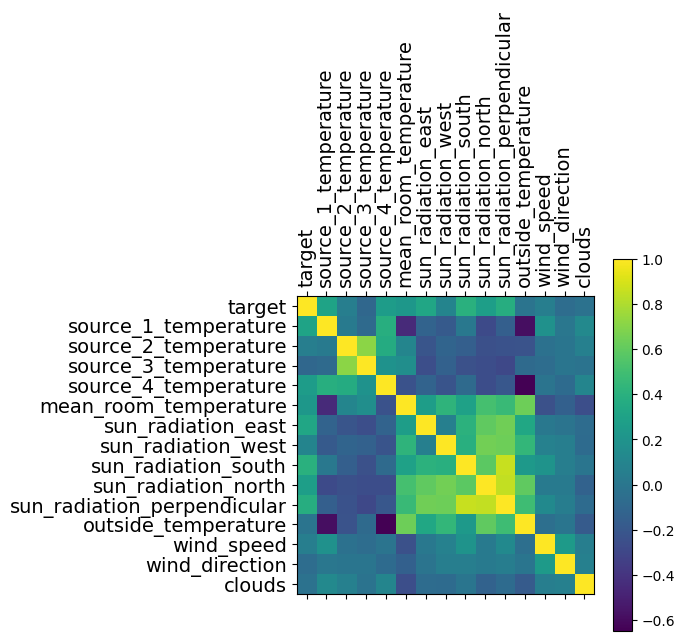

In [7]:
# Matrix of correlation between numerical columns
# only numerical columns are considered not measurement_time
train_numerical = train.drop(['measurement_time'], axis=1)
matrix = train_numerical.corr()
# print highest correlations var 1 var 2 corr
print(matrix.unstack().sort_values().drop_duplicates().tail(10))

plt.matshow(matrix)
# include the column names
plt.xticks(range(train_numerical.shape[1]), train_numerical.columns, fontsize=14, rotation=90)
plt.yticks(range(train_numerical.shape[1]), train_numerical.columns, fontsize=14)
plt.colorbar()
plt.show()

According to  Pearson correlation coefficient, r > 0.75 is considered as highly correlated. This mainly affects our results with radiation values. The following pairs of variables are highly correlated:
sun_radiation_north          sun_radiation_perpendicular    0.847473
sun_radiation_perpendicular  sun_radiation_south            0.861518

Therefore we drop `sun_radiation_perpendicular` column.

In [8]:
# which percentage of the data is explained by all components - sun_radiation_perpendicular
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
# Separate the target column (dependent variable) from the features (independent variables)
X1 = train_numerical.drop(columns=['target'])  # Drop target column to get features
X2 = train_numerical.drop(columns=['target', 'sun_radiation_perpendicular'])
y = train_numerical['target']  # Target column

# Standardize the features (important for PCA)
scaler = StandardScaler()
X1_scaled = scaler.fit_transform(X1)
X2_scaled = scaler.fit_transform(X2)

# Apply PCA (you can adjust n_components as needed)
pca1 = PCA() 
pca2 = PCA()
X1_pca = pca1.fit_transform(X1_scaled)
X2_pca = pca2.fit_transform(X2_scaled)

# Split data into training and testing sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_pca, y, test_size=0.2, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_pca, y, test_size=0.2, random_state=42)
# Fit a linear regression model on the PCA components
model1 = LinearRegression()
model1.fit(X1_train, y1_train)
model2 = LinearRegression()
model2.fit(X2_train, y2_train)

# Predict the target variable on the test set
y1_pred = model1.predict(X1_test)
y2_pred = model2.predict(X2_test)

# Calculate R-squared to see how well the target is predicted by the PCA components
r2v1 = r2_score(y1_test, y1_pred)
r2v2 = r2_score(y2_test, y2_pred)
# Output the amount of variance explained by the PCA components in the target
print(f'R-squared (Variance Explained by PCA Components) when keeping all components: {r2v1:.4f}')
print(f'R-squared (Variance Explained by PCA Components) without sun_radiation_perpendicular: {r2v2:.4f}')

R-squared (Variance Explained by PCA Components) when keeping all components: 0.4308
R-squared (Variance Explained by PCA Components) without sun_radiation_perpendicular: 0.4307


In [9]:
# print the variance explained by the max number of components for each case
print(f"Explained variance by all components - sun_radiation_perpendicular: {pca2.explained_variance_ratio_.sum():.6f}")
print(f"Explained variance by all components: {pca1.explained_variance_ratio_.sum():.6f}")

Explained variance by all components - sun_radiation_perpendicular: 1.000000
Explained variance by all components: 1.000000


In [10]:
# make measurements_time a datetime object
train_datetime = train
train_datetime['measurement_time'] = pd.to_datetime(train_datetime['measurement_time'])
# sort values by measurement_time
train_datetime = train_datetime.sort_values('measurement_time')
# make an aggregation of the target by day
train_datetime = train_datetime.resample('D', on='measurement_time').mean()
train_datetime.reset_index(inplace=True)

In [11]:
train_datetime.head()

,measurement_time,target,source_1_temperature,source_2_temperature,source_3_temperature,source_4_temperature,mean_room_temperature,sun_radiation_east,sun_radiation_west,sun_radiation_south,sun_radiation_north,sun_radiation_perpendicular,outside_temperature,wind_speed,wind_direction,clouds
0,2023-11-01,14.205556,32.366320,19.299305,19.790278,22.275000,20.697020,74.411290,73.115591,203.708333,20.786290,213.783602,11.844167,4.608333,170.000000,82.166667
1,2023-11-02,13.626736,32.595486,19.633333,19.793750,22.437153,20.585914,73.018817,71.720430,202.041667,20.435484,211.069892,11.448750,8.081250,163.333333,78.666667
2,2023-11-03,14.946875,34.522570,19.308333,19.844097,21.767361,20.397134,71.626344,70.325269,200.375000,20.084677,208.356183,9.566250,8.124583,200.000000,80.666667
3,2023-11-04,5.048264,34.539931,19.214583,19.795486,20.977431,19.617871,70.233871,68.930108,198.708333,19.733871,205.642473,9.142917,5.294167,165.833333,89.583333
4,2023-11-05,4.305556,34.313194,18.551389,19.684375,20.278125,19.018945,68.841398,67.534946,197.041667,19.383065,202.928763,10.241250,4.694167,203.333333,72.333333


In [12]:
print(train_datetime['measurement_time'].describe())

count                    294
mean     2024-03-26 12:00:00
min      2023-11-01 00:00:00
25%      2024-01-13 06:00:00
50%      2024-03-26 12:00:00
75%      2024-06-07 18:00:00
max      2024-08-20 00:00:00
Name: measurement_time, dtype: object


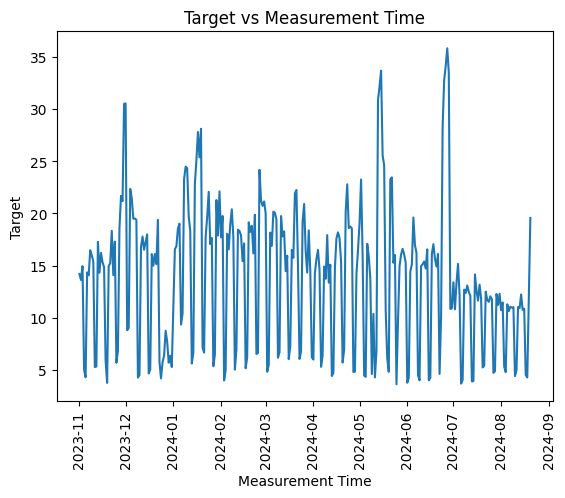

In [13]:
# plot all values of target across measurement_time
plt.plot(train_datetime['measurement_time'], train_datetime['target'])
plt.xlabel('Measurement Time')
plt.ylabel('Target')
plt.title('Target vs Measurement Time')
plt.xticks(rotation=90)
plt.show()

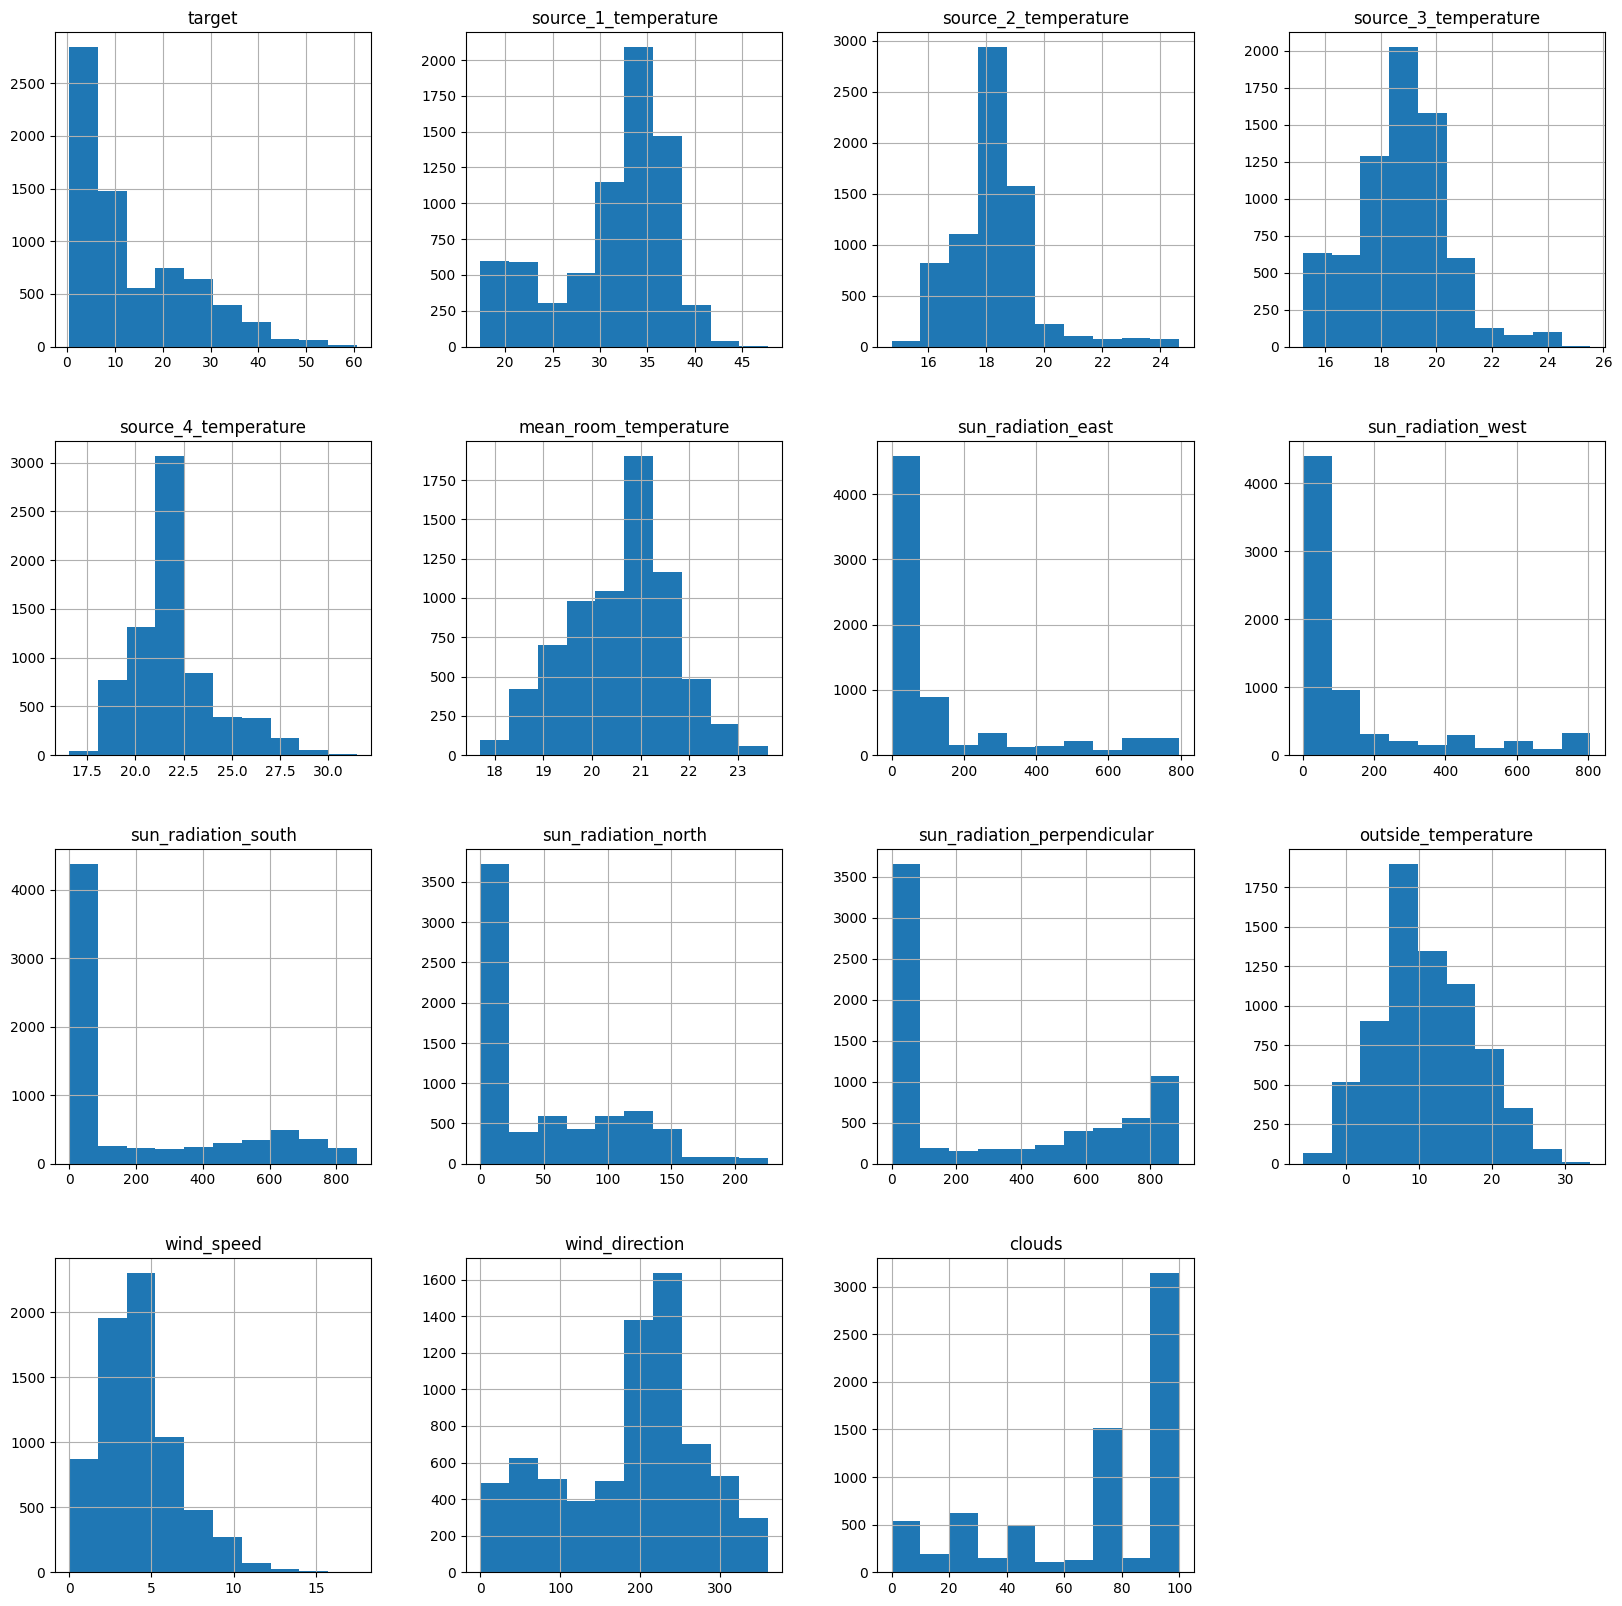

In [14]:
# distribution of all variables
train_numerical.hist(figsize=(20, 20))
plt.show()